In [1]:
# pip install pyhealth

In [2]:
import sys
sys.path.insert(0, "/shared/chaoqiy2/github/PyHealth")

In [3]:
import torch

device = torch.device("cuda:0")

/home/chaoqiy2/miniconda3/envs/moltext/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### STEP 1: load the chest Xray data

In [4]:
from pyhealth.datasets import COVID19CXRDataset

root = "/shared/chaoqiy2/data/COVID-19_Radiography_Dataset"
base_dataset = COVID19CXRDataset(root, refresh_cache=False)

base_dataset.stat()

Statistics of COVID19CXRDataset:
Number of samples: 21165
Number of classes: 4
Class distribution: Counter({'Normal': 10192, 'Lung Opacity': 6012, 'COVID': 3616, 'Viral Pneumonia': 1345})


### STEP 2: set task and processing the data

In [5]:
from torchvision import transforms

sample_dataset = base_dataset.set_task()

# the transformation automatically normalize the pixel intensity into [0, 1]
transform = transforms.Compose([
    transforms.Lambda(lambda x: x if x.shape[0] == 3 else x.repeat(3, 1, 1)), # only use the first channel
    transforms.Resize((128, 128)),
])

def encode(sample):
    sample["path"] = transform(sample["path"])
    return sample

sample_dataset.set_transform(encode)

Generating samples for COVID19CXRClassification: 100%|█| 21165/21165 [00:00<00:00, 3057850.03it/


In [6]:
from pyhealth.datasets import split_by_visit, get_dataloader

# split dataset
train_dataset, val_dataset, test_dataset = split_by_visit(
    sample_dataset, [0.8, 0.1, 0.1]
)
train_dataloader = get_dataloader(train_dataset, batch_size=256, shuffle=True, num_workers=10)
val_dataloader = get_dataloader(val_dataset, batch_size=256, shuffle=False, num_workers=10)
test_dataloader = get_dataloader(test_dataset, batch_size=256, shuffle=False, num_workers=10)

In [7]:
data = next(iter(train_dataloader))
print (data["path"][0].shape)

print(
    "loader size: train/val/test",
    len(train_dataset),
    len(val_dataset),
    len(test_dataset),
)

torch.Size([3, 128, 128])
loader size: train/val/test 16932 2116 2117


### STEP3: define the GAN model

In [18]:
from pyhealth.models import GAN

model = GAN(
    input_channel=3,
    input_size=128,
    hidden_dim = 256,
)

model.to(device)

GAN(
  (discriminator): Sequential(
    (0): ResBlock2D(
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ELU(alpha=1.0)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (downsample): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): ResBlock2D(
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): EL

### STEP4: training the GAN model in an adversarial way

In [19]:
import torch
from tqdm import tqdm

# Loss function
loss = torch.nn.BCELoss()
opt_G = torch.optim.AdamW(model.generator.parameters(), lr=1e-3)
opt_D = torch.optim.AdamW(model.discriminator.parameters(), lr=1e-4)

curve_D, curve_G = [], []

for epoch in range(30):
    curve_G.append(0)
    curve_D.append(0)
    for batch in tqdm(train_dataloader):
        
        """ train discriminator """
        opt_D.zero_grad()

        real_imgs = torch.stack(batch["path"], dim=0).to(device)
        batch_size = real_imgs.shape[0]
        fake_imgs = model.generate_fake(batch_size, device)
        
        real_loss = loss(model.discriminator(real_imgs), torch.ones(batch_size, 1).to(device))
        fake_loss = loss(model.discriminator(fake_imgs.detach()), torch.zeros(batch_size, 1).to(device))
        loss_D = (real_loss + fake_loss) / 2

        loss_D.backward()
        opt_D.step()
        
        """ train generator """
        opt_G.zero_grad()
        loss_G = loss(model.discriminator(fake_imgs), torch.ones(batch_size, 1).to(device))

        loss_G.backward()
        opt_G.step()
        
        curve_G[-1] += loss_G.item()
        curve_D[-1] += loss_D.item()

    print (f"epoch: {epoch} --- loss of G: {curve_G[-1]}, loss of D: {curve_D[-1]}")

100%|███████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.83it/s]


epoch: 0 --- loss of G: 223.14766198396683, loss of D: 14.372084847651422


100%|███████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.08it/s]


epoch: 1 --- loss of G: 466.95815896987915, loss of D: 0.5429049517260864


100%|███████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.01it/s]


epoch: 2 --- loss of G: 541.9039497375488, loss of D: 0.154949375835713


100%|███████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.04it/s]


epoch: 3 --- loss of G: 585.4883279800415, loss of D: 0.08368747876374982


100%|███████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.01it/s]


epoch: 4 --- loss of G: 602.0627527236938, loss of D: 0.05825718602864072


100%|███████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.15it/s]


epoch: 5 --- loss of G: 591.4524450302124, loss of D: 0.13042546913493425


100%|███████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.91it/s]


epoch: 6 --- loss of G: 632.745792388916, loss of D: 0.20137088373303413


100%|███████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.10it/s]


epoch: 7 --- loss of G: 661.4006824493408, loss of D: 0.10395967395743355


100%|███████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.23it/s]


epoch: 8 --- loss of G: 677.7967081069946, loss of D: 0.5532456065993756


100%|███████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.07it/s]


epoch: 9 --- loss of G: 433.70705580711365, loss of D: 22.162632698193192


100%|███████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.08it/s]


epoch: 10 --- loss of G: 229.85241758823395, loss of D: 26.228228241205215


100%|███████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.05it/s]


epoch: 11 --- loss of G: 174.89740097522736, loss of D: 35.14613048732281


100%|███████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.98it/s]


epoch: 12 --- loss of G: 64.26566570997238, loss of D: 49.84083557128906


100%|███████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.12it/s]


epoch: 13 --- loss of G: 55.36016184091568, loss of D: 46.46439307928085


100%|███████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.19it/s]


epoch: 14 --- loss of G: 69.27246510982513, loss of D: 38.82108682394028


100%|███████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.26it/s]


epoch: 15 --- loss of G: 64.44753348827362, loss of D: 47.80539244413376


100%|███████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.10it/s]


epoch: 16 --- loss of G: 61.45279908180237, loss of D: 44.05769336223602


100%|███████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.12it/s]


epoch: 17 --- loss of G: 75.36881673336029, loss of D: 40.88142177462578


100%|███████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.97it/s]


epoch: 18 --- loss of G: 103.49066084623337, loss of D: 37.94770136475563


100%|███████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.11it/s]


epoch: 19 --- loss of G: 91.51107203960419, loss of D: 40.233694821596146


100%|███████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.16it/s]


epoch: 20 --- loss of G: 68.30243217945099, loss of D: 46.852890968322754


100%|███████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.22it/s]


epoch: 21 --- loss of G: 67.08098781108856, loss of D: 40.69077146053314


100%|███████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.13it/s]


epoch: 22 --- loss of G: 71.02358865737915, loss of D: 39.53429859876633


100%|███████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.05it/s]


epoch: 23 --- loss of G: 75.0613711476326, loss of D: 44.871963798999786


100%|███████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.19it/s]


epoch: 24 --- loss of G: 86.96417981386185, loss of D: 39.01591020822525


100%|███████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.03it/s]


epoch: 25 --- loss of G: 71.5315232872963, loss of D: 42.92875400185585


100%|███████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.05it/s]


epoch: 26 --- loss of G: 83.02981567382812, loss of D: 35.7115815281868


100%|███████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.17it/s]


epoch: 27 --- loss of G: 79.00199449062347, loss of D: 44.660759538412094


100%|███████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.24it/s]


epoch: 28 --- loss of G: 76.95186269283295, loss of D: 39.98225525021553


100%|███████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.02it/s]

epoch: 29 --- loss of G: 68.42279094457626, loss of D: 42.02642643451691


### EXP 2: synthesize random images

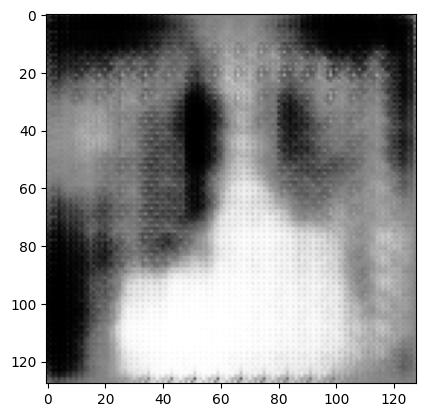

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    fake_imgs = model.generate_fake(1, device).detach().cpu()
    plt.imshow(fake_imgs[0][0], cmap="gray")
    plt.show()